In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
df.head()
df.isnull().sum()

title                              0
location                         354
description                        0
requirements                    2772
telecommuting                      0
has_company_logo                   0
has_questions                      0
fraudulent                         0
location_has_non_latin             0
description_has_non_latin          0
requirements_has_non_latin         0
has_requirements                   0
description_and_requirements       0
country_state                   2599
country                          354
has_location                       0
has_location_details               0
dtype: int64

In [11]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
# location, description, requirements will be dropped.
# ['country_state', 'country'] are dropped for now, will decide once location column is filled in
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+y_col].dropna()

df2["combined_text"] = df2["title"] + " " + df2["description_and_requirements"]
X_text_cols = ["combined_text"]

X = df2[X_numeric_cols+X_text_cols]
y = df2[y_col]

In [12]:
###########################
##### Train the model #####
###########################

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("text_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "combined_text"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(random_state=42, max_iter=1000))
])

model.fit(X_train, y_train)

# Make predictions and print classification report
y_pred = model.predict(X_test)

/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3410
           1       0.97      0.55      0.70       257

    accuracy                           0.97      3667
   macro avg       0.97      0.77      0.84      3667
weighted avg       0.97      0.97      0.96      3667

F2 Score: 0.6010230179028133
[[-0.0251709   1.06088599 -0.26574446 ...  0.25869464 -0.42745866
  -0.030642  ]]


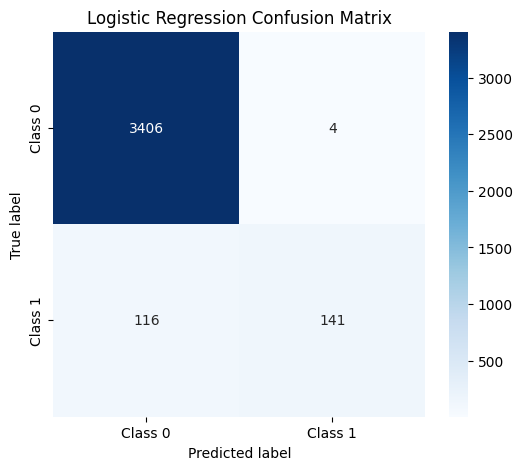

In [13]:
###########################
##### Display results #####
###########################

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2, average='binary'))
clf = model.named_steps["clf"]
print(clf.coef_)
fbeta = make_scorer(fbeta_score, beta=2)
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), f"Logistic Regression Confusion Matrix")